## Build A Basic ChatBot With LangGraph(Graph API)

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages

add_messages is a one reducer which helps to store information in state variable by appending.
It appends in new information in that variable.

In [3]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwritin them)
    messages:Annotated[list,add_messages]



In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
#There are 2 ways to interact with llms 
from langchain_groq import ChatGroq # 1st Way
from langchain.chat_models import init_chat_model  # 2nd Way

llm=ChatGroq(model="llama3-8b-8192")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000024726BD5310>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024726D248F0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000024726D250D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024726D25610>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
# For Every node there is a node defination
def chatbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]} 

In [9]:
graph_builder = StateGraph(State)

#add node
graph_builder.add_node("llmchatbot",chatbot)
#add edge
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)


# compile the Graph
graph=graph_builder.compile()

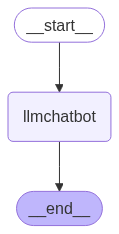

In [10]:
##Visualize the graph
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
responce=graph.invoke({'messages':"Hi"})

In [12]:
responce["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [13]:
for event in graph.stream({"messages":"Hii how are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! I'm just an AI, so I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How about you? How's your day going so far?


# ChatBot With Tool

In [14]:
from langchain_tavily import TavilySearch

tool= TavilySearch(max_results=2)
tool.invoke("What is Langgraph")

{'query': 'What is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [15]:
# what is doc stream ---- Here the data in triple "" is a doc stream
def multiply(a:int,b:int)->int:
    """
    Multiply a and b

    Args :
        a (int): first int
        b (int): second int
    Returns :
        int: output int
    """
    return a*b

In [16]:
tools = [tool,multiply]

In [17]:
llm_with_tool=llm.bind_tools(tools)

In [18]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000024726D250D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000024726D25610>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [19]:
class State(TypedDict):
    # Messages have the type "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwritin them)
    messages:Annotated[list,add_messages]


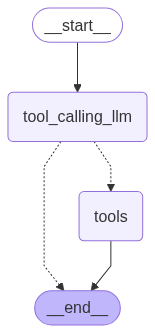

In [20]:
## StateGraph
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Defination 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call - > tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call - > tools_condition routes to END
    tools_condition
)

builder.add_edge("tools",END)

## Compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png())) 






In [21]:
responce=graph.invoke({"messages":"What is the recent ai news"})

In [22]:
responce['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4008912/wormgpt-returns-new-malicious-ai-variants-built-on-grok-and-mixtral-uncovered.html", "title": "WormGPT returns: New malicious AI variants built on Grok and Mixtral uncovered - csoonline.com", "score": 0.70214266, "published_date": "Wed, 18 Jun 2025 12:17:59 GMT", "content": "news ### New npm threats can erase production systems with a single request Jun 10, 2025 3 mins\\n   news ### Chrome extension privacy promises undone by hardcoded secrets, leaky HTTP Jun 9, 2025 4 mins\\n   news ### New phishing campaign hijacks clipboard via fake CAPTCHA for malware delivery Jun 6, 2025 4 mins\\n   news ### Supply chain attack hits RubyGems to steal Telegram API data Jun 5, 2025 4 mins [...] Related content\\n---------------\\n\\nOpinion ### Security, risk and compliance in the world of AI agents By Nikhil Sarnot Jun 17, 2025 12 mins Artificial Int

In [23]:
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kvnc57g6k)
 Call ID: kvnc57g6k
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4008912/wormgpt-returns-new-malicious-ai-variants-built-on-grok-and-mixtral-uncovered.html", "title": "WormGPT returns: New malicious AI variants built on Grok and Mixtral uncovered - csoonline.com", "score": 0.70214266, "published_date": "Wed, 18 Jun 2025 12:17:59 GMT", "content": "news ### New npm threats can erase production systems with a single request Jun 10, 2025 3 mins\n   news ### Chrome extension privacy promises un

In [24]:
responce=graph.invoke({"messages":"What is 2 multiplied by 3 and then multiply by 10"})
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (gkwtg6j74)
 Call ID: gkwtg6j74
  Args:
    a: 2
    b: 3
  multiply (87kyv9n91)
 Call ID: 87kyv9n91
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

60


In [25]:
responce=graph.invoke({"messages":"Give me recent ai news and 2 multiplied by 3 and then multipy by 10"})
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me recent ai news and 2 multiplied by 3 and then multipy by 10
================================== Ai Message ==================================

/tool-use>
{
    "tool_calls": [
        {
            "id": "pending",
            "type": "function",
            "function": {
                "name": "tavily_search"
            },
            "parameters": {
                "query": "recent ai news",
                "search_depth": "advanced",
                "time_range": "day"
            }
        },
        {
            "id": "pending",
            "type": "function",
            "function": {
                "name": "multiply"
            },
            "parameters": {
                "a": 2,
                "b": 3
            }
        },
        {
            "id": "pending",
            "type": "function",
            "function": {
                "name": "multiply"
            },
            "

# ReACT Agent Architecture

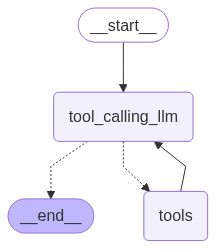

In [26]:
## StateGraph
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Defination 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call - > tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call - > tools_condition routes to END
    tools_condition
)
 
builder.add_edge("tools","tool_calling_llm") #change
builder.add_edge("tool_calling_llm",END) # change
## Compile the graph
graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png())) 

In [27]:
responce=graph.invoke({"messages" : "Give me the recent ai news and then multiply 5 by 10"})
for m in responce['messages']:
    m.pretty_print()


================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (c71eftefv)
 Call ID: c71eftefv
  Args:
    query: recent ai news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.csoonline.com/article/4008912/wormgpt-returns-new-malicious-ai-variants-built-on-grok-and-mixtral-uncovered.html", "title": "WormGPT returns: New malicious AI variants built on Grok and Mixtral uncovered - csoonline.com", "score": 0.70214266, "published_date": "Wed, 18 Jun 2025 12:17:59 GMT", "content": "news ### New npm threats can erase production systems with a single request Jun 10, 2025 3 mins\n   news ### Chrome ext

# Adding Memory In Agentic Graph

In [28]:
responce=graph.invoke({"messages" : "Heyyy! My Name is Namit"})
for m in responce['messages']:
    m.pretty_print()


================================ Human Message =================================

Heyyy! My Name is Namit
================================== Ai Message ==================================

Nice to meet you, Namit! How can I assist you today?


In [29]:
responce=graph.invoke({"messages" : "What is My name"})
for m in responce['messages']:
    m.pretty_print()

================================ Human Message =================================

What is My name
================================== Ai Message ==================================

I'm happy to help you with that! However, I don't have any information about your name. Could you please provide me with more context or clarify what you mean by "My name"? Are you asking about your username, your real name, or something else?


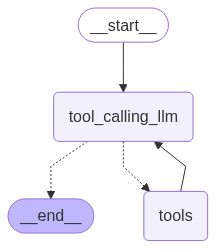

In [30]:
## StateGraph
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver #chnage

memory = MemorySaver() #change

# Node Defination 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

# Add Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call - > tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call - > tools_condition routes to END
    tools_condition
)
 
builder.add_edge("tools","tool_calling_llm") #change
builder.add_edge("tool_calling_llm",END) # change
## Compile the graph
graph=builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png())) 

In [31]:
config={"configurable":{'thread_id':"1"}}

responce=graph.invoke({"messages":"My name is Namit"},config=config)
responce

{'messages': [HumanMessage(content='My name is Namit', additional_kwargs={}, response_metadata={}, id='69cc6a67-ed29-4a37-b373-bbd7a841e7fd'),
  AIMessage(content='Nice to meet you, Namit!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 2204, 'total_tokens': 2213, 'completion_time': 0.014655738, 'prompt_time': 0.431755542, 'queue_time': 0.6111733380000001, 'total_time': 0.44641128}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--c6bcb08d-d695-4e13-9536-63f27bc37347-0', usage_metadata={'input_tokens': 2204, 'output_tokens': 9, 'total_tokens': 2213})]}

In [32]:
responce['messages'][-1].content

'Nice to meet you, Namit!'

In [33]:
responce=graph.invoke({"messages":"tell  My Name"},config=config)

In [34]:
responce['messages'][-1].content

'Based on the result of the tool call id "f4e9jts72", I see that you are interested in learning more about the name "Namit". \n\nHere\'s a summary of what I found: \n\n- Namit is generally perceived as a positive and meaningful name, carrying connotations of humility, reverence, and sincerity.\n- It is appreciated for its cultural significance and unique sound.\n- The name Namit is associated with positive feelings such as being humble, respectful, sincere, kind, intelligent, grounded, spiritual, strong, and unique.\n- According to namediscoveries.com, the name Namit is of Indian origin and has a meaning and origin that reflects creativity, communication, charisma, and independence.\n\nI hope this information helps you understand more about the name "Namit". Let me know if you have any further questions or if there\'s anything else I can help you with!'

# Streaming

In [35]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [36]:
def superbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}

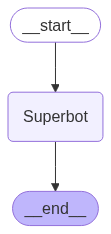

In [37]:
graph=StateGraph(State)

#node 
graph.add_node("Superbot",superbot)

#edge
graph.add_edge(START,"Superbot")
graph.add_edge("Superbot",END)

graph_builder=graph.compile(checkpointer=memory)

## Display
from IPython.display import display , Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [38]:
## Invocation 

config={"configurable":{'thread_id':"1"}}

graph_builder.invoke({"messages":"Hii, My name is Namit And I Like Cricket"},config)


{'messages': [HumanMessage(content='Hii, My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='854d176f-6e22-4c65-91d7-4786e9209e41'),
  AIMessage(content="Hello Namit! Nice to meet you! Cricket is a fantastic sport, isn't it? Who's your favorite cricketer or team? Do you play cricket yourself or are you more of a fan?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 22, 'total_tokens': 65, 'completion_time': 0.07880329, 'prompt_time': 0.009938416, 'queue_time': 2.275033939, 'total_time': 0.088741706}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--49cec53d-c645-41e9-8e3c-e88b9fea27b4-0', usage_metadata={'input_tokens': 22, 'output_tokens': 43, 'total_tokens': 65})]}

### Streaming
Methods: . stream() and astream()
- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values**: This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [39]:
## Create a thread 
config={"configurable":{'thread_id':"3"}}

for chunk in graph_builder.stream({'messages':"Hii,My name is Namit And I Like Cricket"},config,stream_mode="updates"):
    print (chunk)


{'Superbot': {'messages': [AIMessage(content="Hi Namit! Nice to meet you! Cricket is a fantastic sport, isn't it? Which team do you support? Do you have a favorite player or a favorite match or series that you remember vividly?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 22, 'total_tokens': 66, 'completion_time': 0.079172133, 'prompt_time': 0.021423037, 'queue_time': 0.150452732, 'total_time': 0.10059517}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5e01ecc-2277-4397-8be2-de6b3896ece7-0', usage_metadata={'input_tokens': 22, 'output_tokens': 44, 'total_tokens': 66})]}}


In [40]:
for chunk in graph_builder.stream({'messages':"Hii,My name is Namit And I Like Cricket"},config,stream_mode="values"):
    print (chunk)

{'messages': [HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='37344ae1-cbd7-403b-b77f-12d87fbbeb07'), AIMessage(content="Hi Namit! Nice to meet you! Cricket is a fantastic sport, isn't it? Which team do you support? Do you have a favorite player or a favorite match or series that you remember vividly?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 22, 'total_tokens': 66, 'completion_time': 0.079172133, 'prompt_time': 0.021423037, 'queue_time': 0.150452732, 'total_time': 0.10059517}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--e5e01ecc-2277-4397-8be2-de6b3896ece7-0', usage_metadata={'input_tokens': 22, 'output_tokens': 44, 'total_tokens': 66}), HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='b17f02b3-b683-4898-8954-15860cf1a6ae')

In [41]:
## Create a thread 
config={"configurable":{'thread_id':"4"}}

for chunk in graph_builder.stream({'messages':"Hii,My name is Namit And I Like Cricket"},config,stream_mode="updates"):
    print (chunk)

{'Superbot': {'messages': [AIMessage(content="Hi Namit! Nice to meet you! Cricket is a wonderful sport, isn't it? Which team do you support? Are you a fan of the Indian national team or do you have a soft spot for a different team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 22, 'total_tokens': 69, 'completion_time': 0.121644983, 'prompt_time': 0.022121015, 'queue_time': 0.23518305400000003, 'total_time': 0.143765998}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0d61242d-9855-4508-9b4b-6aaaceb88761-0', usage_metadata={'input_tokens': 22, 'output_tokens': 47, 'total_tokens': 69})]}}


In [42]:
for chunk in graph_builder.stream({'messages':"I also Like Football"},config,stream_mode="values"):
    print (chunk)

{'messages': [HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='af5d563b-333b-444b-84f8-fe16fc7696a1'), AIMessage(content="Hi Namit! Nice to meet you! Cricket is a wonderful sport, isn't it? Which team do you support? Are you a fan of the Indian national team or do you have a soft spot for a different team?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 22, 'total_tokens': 69, 'completion_time': 0.121644983, 'prompt_time': 0.022121015, 'queue_time': 0.23518305400000003, 'total_time': 0.143765998}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_24ec19897b', 'finish_reason': 'stop', 'logprobs': None}, id='run--0d61242d-9855-4508-9b4b-6aaaceb88761-0', usage_metadata={'input_tokens': 22, 'output_tokens': 47, 'total_tokens': 69}), HumanMessage(content='I also Like Football', additional_kwargs={}, response_metadata={}, id='adf87193-9b8f-4d7b-9b54-c5fa1d46bcd8')]}
{'m

In [43]:
# Async Method proviedes More Detailed information
config={"configurable":{'thread_id':"5"}}

async for chunk in graph_builder.astream_events({'messages':"Hii,My name is Namit And I Like Cricket"},config,version="v2"):
    print (chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hii,My name is Namit And I Like Cricket'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'ef028b0f-83ff-48f0-bc54-cedfa78c104d', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_kwargs={}, response_metadata={}, id='9fc09b98-986e-41e0-b93c-9d3528fac85b')]}}, 'name': 'Superbot', 'tags': ['graph:step:1'], 'run_id': '2202171c-a961-46d2-9e85-a701c7e49cbd', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'Superbot', 'langgraph_triggers': ('branch:to:Superbot',), 'langgraph_path': ('__pregel_pull', 'Superbot'), 'langgraph_checkpoint_ns': 'Superbot:0aac9996-888f-b650-418e-1aec48515523'}, 'parent_ids': ['ef028b0f-83ff-48f0-bc54-cedfa78c104d']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hii,My name is Namit And I Like Cricket', additional_